In [101]:
import pandas as pd
from pathlib import Path
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime
import re
from scipy import stats
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from matplotlib import colormaps
from tqdm.notebook import tqdm
import helpers
import statsmodels.formula.api as smf

from mri_data import file_manager as fm

In [174]:
drive_root = fm.get_drive_root()
dataroot = drive_root / "3Tpioneer_bids"
data_dir = Path("/home/srs-9/Projects/ms_mri/data")
fig_path = Path("/home/srs-9/Projects/ms_mri/choroid_thalamus_project/figures")

choroid_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/choroid_aschoplex_volumes.csv", index_col="subid"
).dropna()
tiv = pd.read_csv("/home/srs-9/Projects/ms_mri/data/tiv_data.csv", index_col="subid")

df = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/clinical_data_processed.csv", index_col="subid"
)
df['thalamus_sqrt'] = np.sqrt(df['thalamus'])
df['thalamus_curt'] = np.sqrt(df['thalamus']**3)
df = df.join([choroid_volumes, tiv])
df = helpers.get_mri_edss_delta(df)
df_z = df.copy()
numeric_cols = df.select_dtypes(include='number').columns
df_z[numeric_cols] = df_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

df_ms = df[df['dz_type2'] == "MS"]
df_ms_z = df_ms.copy()
df_ms_z[numeric_cols] = df_ms_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

viridis = colormaps['viridis'].resampled(20)

colors = helpers.get_colors()

/tmp/ipykernel_3434964/2927318737.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['thalamus_sqrt'] = np.sqrt(df['thalamus'])
/tmp/ipykernel_3434964/2927318737.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['thalamus_curt'] = np.sqrt(df['thalamus']**3)
/home/srs-9/Projects/ms_mri/analysis/thalamus/helpers.py:222: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axi

(13.035159742672137,
 0.01110526886468004,
 3.316725631918206,
 0.010762198186609435)

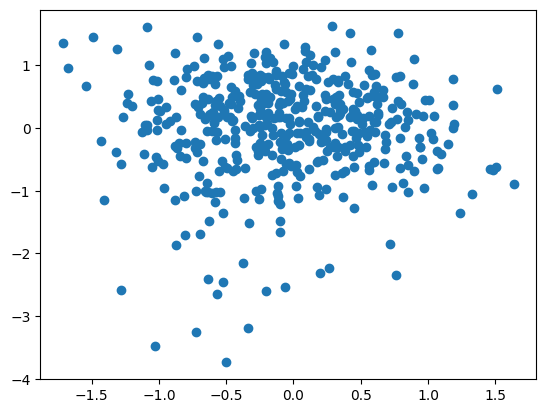

In [56]:
model_data = df_z.copy()
model_data = model_data[model_data['dz_type2'] == "MS"]
# model_data = model_data[model_data['t2lv'] < 4]

formula = "thalamus ~ choroid_volume + age + Female + tiv"
res = sm.OLS.from_formula(formula, data=model_data).fit()

pred = res.predict(model_data)
plt.scatter(res.fittedvalues, res.resid)
het_breuschpagan(res.resid, res.model.exog)

In [ ]:
model_data['e']

In [181]:
model_data = df_z.copy()
model_data = model_data[model_data['dz_type2'] == "MS"]
# model_data.loc[model_data['EDSS_sqrt'].isna(), 'EDSS_sqrt'] = model_data['EDSS_sqrt'].median()
# model_data.loc[model_data['choroid_volume'].isna(), 'choroid_volume'] = model_data['choroid_volume'].median()

formula = "EDSS_sqrt ~ choroid_volume*t2lv_logtrans + Female + tiv + age"
res = sm.OLS.from_formula(formula, data=model_data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              EDSS_sqrt   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     23.90
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           1.55e-24
Time:                        15:12:10   Log-Likelihood:                -583.06
No. Observations:                 452   AIC:                             1180.
Df Residuals:                     445   BIC:                             1209.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [185]:
model_data.loc[model_data['tiv'].isna(), 'choroid_volume']

subid
1196    0.668749
Name: choroid_volume, dtype: float64

In [88]:
from pyprocessmacro import Process

model_data = df_z.copy()
model_data = model_data[model_data['dz_type2'] == "MS"]

p2 = Process(data=model_data, model=5, x="t2lv_logtrans", y="EDSS_sqrt", w="choroid_volume",
            m=["thalamus"],
            controls=["age", "Female", "tiv"],
            controls_in="all")
p2.summary()

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:1567: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  grad = eval_expression(


Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 5

Variables:
    Cons = Cons
    x = t2lv_logtrans
    y = EDSS_sqrt
    w = choroid_volume
    m1 = thalamus
Statistical Controls:
 age, Female, tiv



Sample size:
468

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = EDSS_sqrt 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2751   0.2620 0.7541 23.9674    7  442   0.0000

Coefficients

                               coeff     se       t      p    LLCI    ULCI
Cons                         -0.0382 0.0444 -0.8607 0.3899 -0.1253  0.0488
t2lv_logtrans                 0.0387 0.0514  0.7531 0.4518 -0.0621  0.1395
choroid_volume               -

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:738: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_x_to_m = eval_expression(der_x_to_m, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:739: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_m_to_y = eval_expression(der_m_to_y, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:752: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  llci, ulci = bias_corrected_ci(e, be, conf)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmac

In [122]:
model_data = df_z.copy()
model_data = model_data[model_data['dz_type2'] == "MS"]
model_data.loc[model_data['EDSS_sqrt'].isna(), 'EDSS_sqrt'] = model_data['EDSS_sqrt'].median()

formula = "EDSS_sqrt ~ t2lv_logtrans + thalamus + age + Female + tiv"
res = sm.OLS.from_formula(formula, data=model_data).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              EDSS_sqrt   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     33.66
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           2.61e-29
Time:                        14:27:04   Log-Likelihood:                -587.77
No. Observations:                 467   AIC:                             1188.
Df Residuals:                     461   BIC:                             1212.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0153      0.040     -0.382